In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import fidle.pwk as pwk

image104.jpg
image104.dat


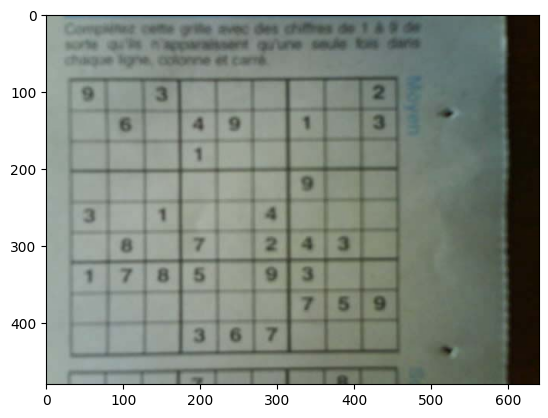

   sonyEricsson w660i
0      640x480:24 JPG
1  9 0 3 0 0 0 0 0 2 
2  0 6 0 4 9 0 1 0 3 
3  0 0 0 1 0 0 0 0 0 
4  0 0 0 0 0 0 9 0 0 
5  3 0 1 0 0 4 0 0 0 
6  0 8 0 7 0 2 4 3 0 
7  1 7 8 5 0 9 3 0 0 
8  0 0 0 0 0 0 7 5 9 
9  0 0 0 3 6 7 0 0 0 


In [8]:
folder=r"v1_training/image"
S_folder=r"v1_training/Solution"
import os
import random

filename=os.listdir(folder)
S_filename=os.listdir(S_folder)
i = random.choice(range(len(folder)))
Grille = filename[i]
solution= S_filename[i]
"Grille=random.choice(os.listdir(folder))"

print(Grille)
sudoku_Grille = cv2.imread(folder + '/' + Grille)
print(solution)
if sudoku_Grille is not None:
	plt.figure()
	plt.imshow(cv2.cvtColor(sudoku_Grille, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
	plt.show()
else:
	print(f"Error: Unable to load image {folder + '/' + Grille}")
df = pd.read_csv(os.path.join(S_folder, solution), delimiter="\t")  # ou delimiter=";" ou ","
print(df)


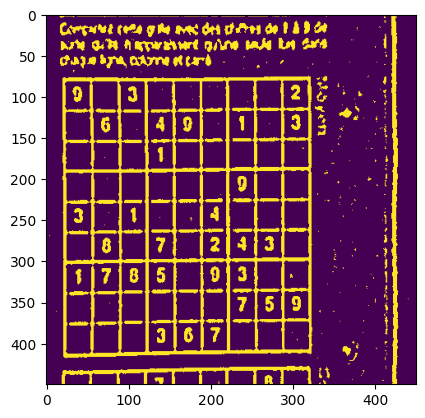

In [9]:
#Preprocessing image to be read
sudoku_Grille = cv2.resize(sudoku_Grille, (450,450))

# function to greyscale, blur and change the receptive threshold of image
def preprocess(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    blur = cv2.GaussianBlur(gray, (3,3),6) 
    #blur = cv2.bilateralFilter(gray,9,75,75)
    threshold_img = cv2.adaptiveThreshold(blur,255,1,1,11,2)
    return threshold_img

threshold = preprocess(sudoku_Grille)

#let's look at what we have got
plt.figure()
plt.imshow(threshold)
plt.show()

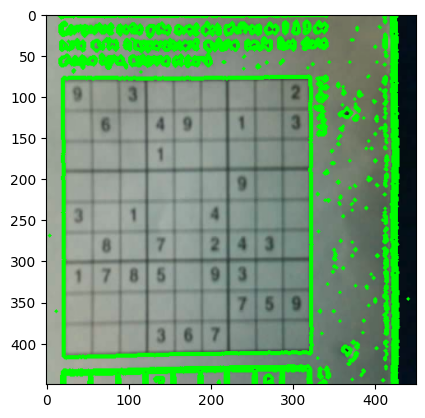

In [10]:
# Finding the outline of the sudoku puzzle in the image
contour_1 = sudoku_Grille.copy()
contour_2 = sudoku_Grille.copy()
contour, hierarchy = cv2.findContours(threshold,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(contour_1, contour,-1,(0,255,0),3)

#let's see what we got
plt.figure()
plt.imshow(contour_1)
plt.show()

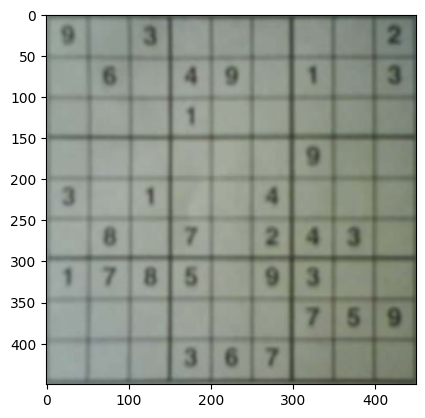

In [11]:
def main_outline(contour):
    biggest = np.array([])
    max_area = 0
    for i in contour:
        area = cv2.contourArea(i)
        if area >50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i , 0.02* peri, True)
            if area > max_area and len(approx) ==4:
                biggest = approx
                max_area = area
    return biggest ,max_area

def reframe(points):
    points = points.reshape((4, 2))
    points_new = np.zeros((4,1,2),dtype = np.int32)
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)]
    points_new[3] = points[np.argmax(add)]
    diff = np.diff(points, axis =1)
    points_new[1] = points[np.argmin(diff)]
    points_new[2] = points[np.argmax(diff)]
    return points_new

def splitcells(img):
    rows = np.vsplit(img,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes


black_img = np.zeros((450,450,3), np.uint8)
biggest, maxArea = main_outline(contour)
if biggest.size != 0:
    biggest = reframe(biggest)
    cv2.drawContours(contour_2,biggest,-1, (0,255,0),10)
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
    matrix = cv2.getPerspectiveTransform(pts1,pts2)  
    imagewrap = cv2.warpPerspective(sudoku_Grille,matrix,(450,450))
    imagewrap =cv2.cvtColor(imagewrap, cv2.COLOR_BGRA2RGB)
    
plt.figure()
plt.imshow(imagewrap)
plt.show()

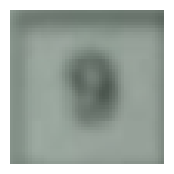

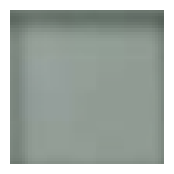

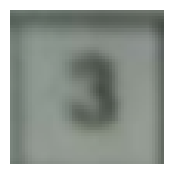

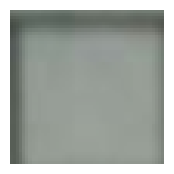

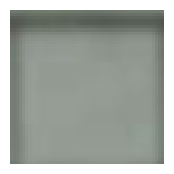

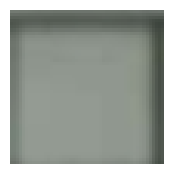

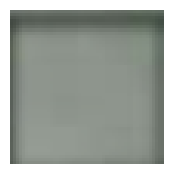

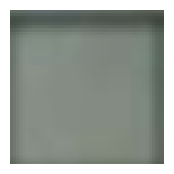

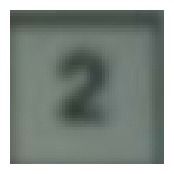

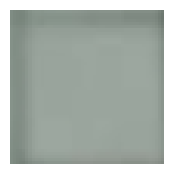

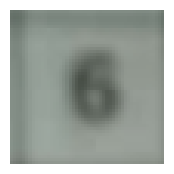

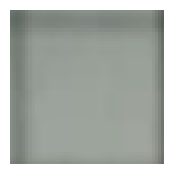

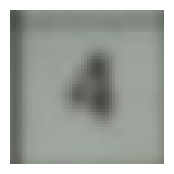

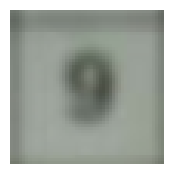

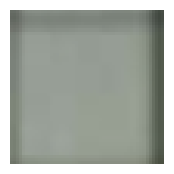

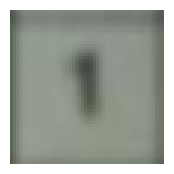

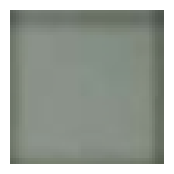

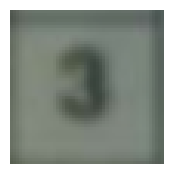

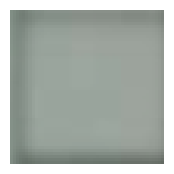

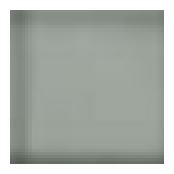

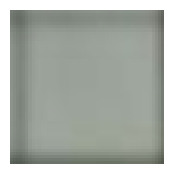

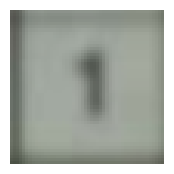

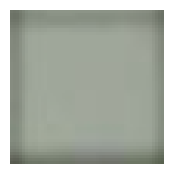

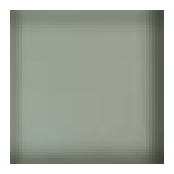

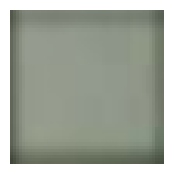

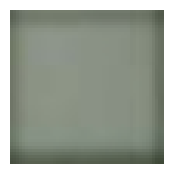

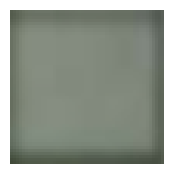

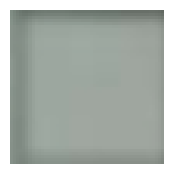

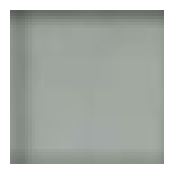

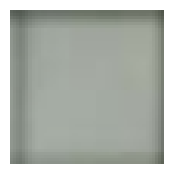

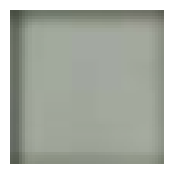

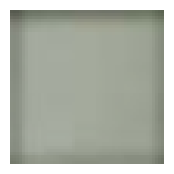

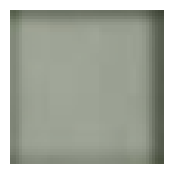

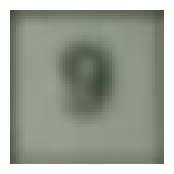

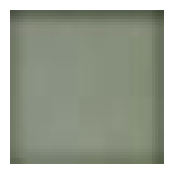

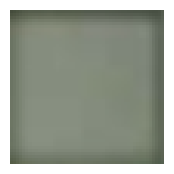

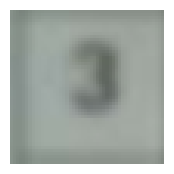

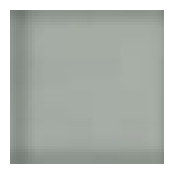

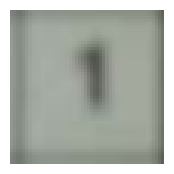

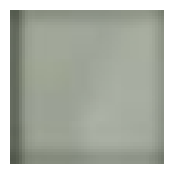

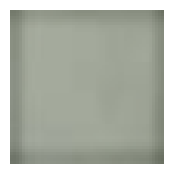

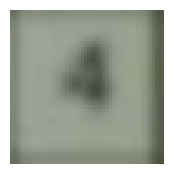

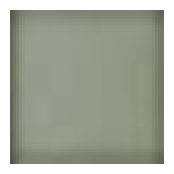

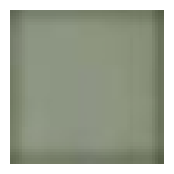

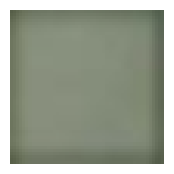

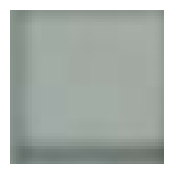

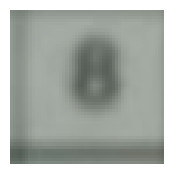

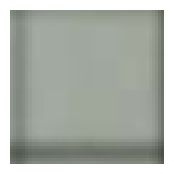

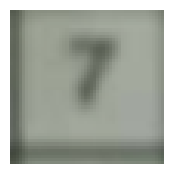

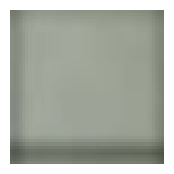

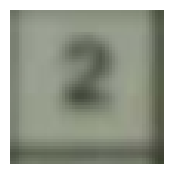

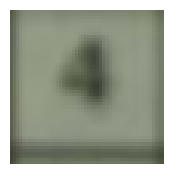

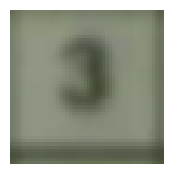

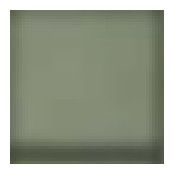

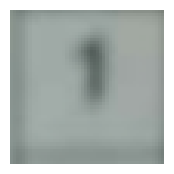

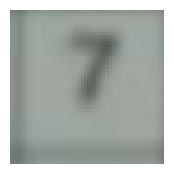

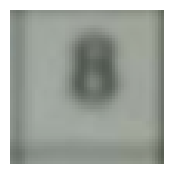

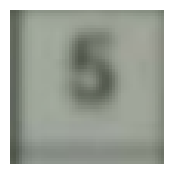

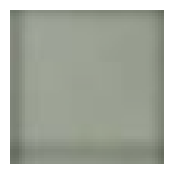

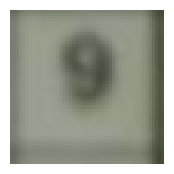

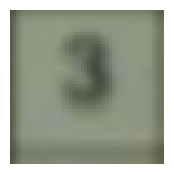

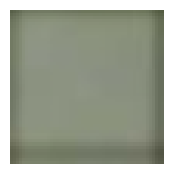

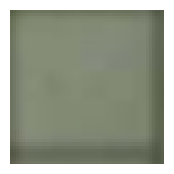

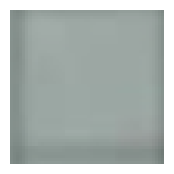

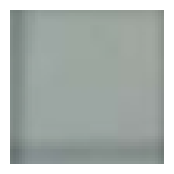

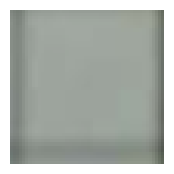

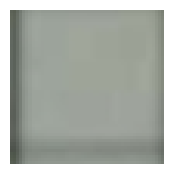

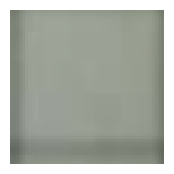

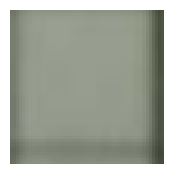

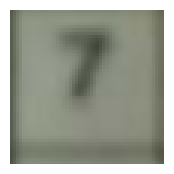

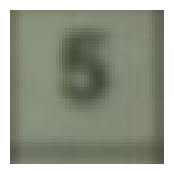

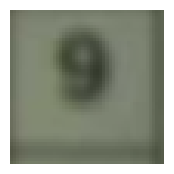

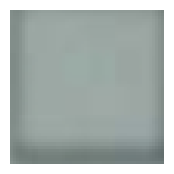

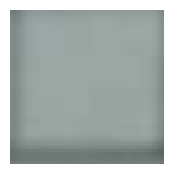

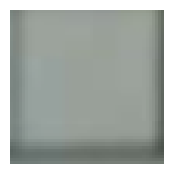

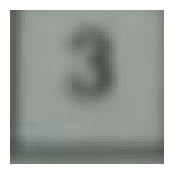

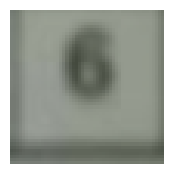

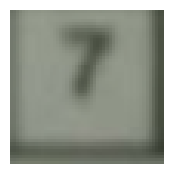

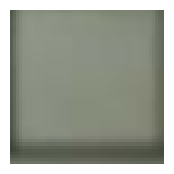

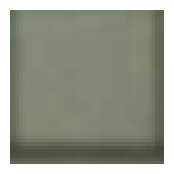

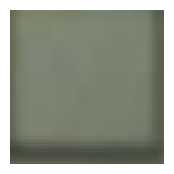

In [12]:
# Découper la grille en 81 cases à l'aide de la fonction splitcells définie précédemment
cases = splitcells(imagewrap)

# Afficher chaque case séparément sans afficher les chiffres ni sauvegarder
for idx, case_img in enumerate(cases):
    plt.figure(figsize=(2,2))
    plt.imshow(case_img)
    plt.axis('off')
    plt.show()


In [13]:
df = pd.read_csv(os.path.join(S_folder, solution), delimiter="\t")  # ou delimiter=";" ou ","
# Afficher uniquement les chiffres (lignes 1 à 9)
for row in df.iloc[1:].itertuples(index=False):
    print(row[0])
# Convertir les chiffres en une liste de listes
sudoku = []
for row in df.iloc[1:].itertuples(index=False):
    sudoku.append([int(num) for num in row[0].split()])
print(sudoku)

9 0 3 0 0 0 0 0 2 
0 6 0 4 9 0 1 0 3 
0 0 0 1 0 0 0 0 0 
0 0 0 0 0 0 9 0 0 
3 0 1 0 0 4 0 0 0 
0 8 0 7 0 2 4 3 0 
1 7 8 5 0 9 3 0 0 
0 0 0 0 0 0 7 5 9 
0 0 0 3 6 7 0 0 0 
[[9, 0, 3, 0, 0, 0, 0, 0, 2], [0, 6, 0, 4, 9, 0, 1, 0, 3], [0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 9, 0, 0], [3, 0, 1, 0, 0, 4, 0, 0, 0], [0, 8, 0, 7, 0, 2, 4, 3, 0], [1, 7, 8, 5, 0, 9, 3, 0, 0], [0, 0, 0, 0, 0, 0, 7, 5, 9], [0, 0, 0, 3, 6, 7, 0, 0, 0]]


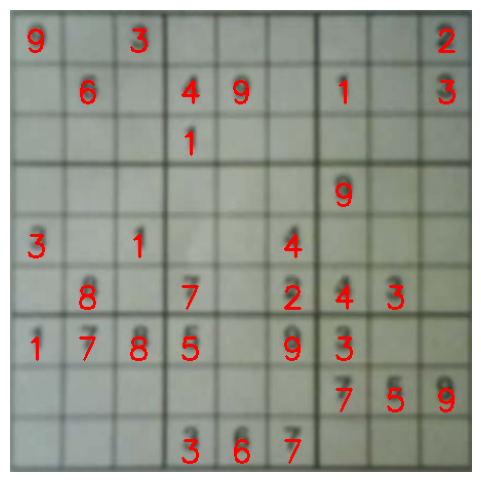

In [14]:
# Initialize the variable
chiffre = 0

# Define the function
def case(chiffre):
    # Create empty lists for horizontal and vertical coordinates
    horizontal = []
    vertical = []
    
    # Generate grid coordinates
    for i in range(9):
        horizontal.append([50 * i, 50 * (i + 1)])
        vertical.append([50 * i, 50 * (i + 1)])
    
    # Draw rectangles and add text if chiffre is valid
    if chiffre in range(0, 9):
        for i in range(9):
            for j in range(9):
                cv2.rectangle(imagewrap, (horizontal[i][0], vertical[j][0]), (horizontal[i][1], vertical[j][1]), (0, 255, 0), 3)
                cv2.putText(imagewrap, str(chiffre), (horizontal[i][0] + 5, vertical[j][0] + 35), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    # Return the modified image
    return imagewrap

# Call the function and display the result
# Afficher la solution dans la grille du sudoku
for i in range(9):
    for j in range(9):
        if sudoku[i][j] != 0:
            cv2.putText(
                imagewrap,
                str(sudoku[i][j]),
                (j * 50 + 15, i * 50 + 40),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (255, 0, 0),
                2
            )

plt.figure(figsize=(6,6))
plt.imshow(imagewrap)
plt.axis('off')
plt.show()



    